In [0]:
import numpy as np
import tensorflow as tf
import gym
import matplotlib.pyplot as plt
import os
import cv2 as cv

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

%matplotlib inline

In [0]:
# for atari game support
!pip install gym[atari]

Shape =  (210, 160, 3)
Action space size: Action  4
['NOOP', 'FIRE', 'RIGHT', 'LEFT']


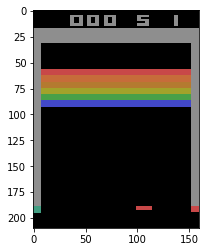

In [0]:
env = gym.make('BreakoutDeterministic-v4')

frame = env.reset()
plt.figure()
plt.imshow(frame)

totalActions = env.action_space.n

print("Shape = ",frame.shape)
print("Action space size: Action  {}".format(totalActions))
print(env.unwrapped.get_action_meanings())

env.close()

In [0]:
def preprocess(img):
    grayImg = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
    resized = cv.resize(grayImg,(84,110))
    preProcessedImg = resized[:84,:84]
    
    return preProcessedImg

(84, 84) uint8


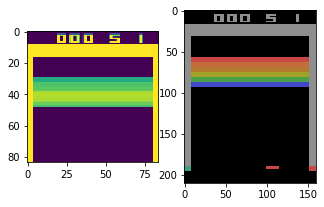

In [0]:
fig = plt.figure(figsize=(8,8))
newFrame = preprocess(frame)
print(newFrame.shape,newFrame.dtype)

fig.add_subplot(1,3,1)
plt.imshow(newFrame)

fig.add_subplot(1,3,2)
plt.imshow(frame)
plt.show()

In [0]:
class atariAgent():
    """ Atari Agent contains the model and functions to predict and train the agent"""
    def __init__(self,totalActions,scope = "agent"):
        self.scope = scope
        self.totalActions = totalActions
        with tf.variable_scope(self.scope):
            self.QModel()
    
    def QModel(self):
        """Contains the model"""
        self.Xin = tf.placeholder(shape=[None,84,84,4],dtype=tf.uint8,name='Xin')
        self.y = tf.placeholder(shape=[None],dtype=tf.float32,name='yin')
        self.actions = tf.placeholder(shape=[None],dtype=tf.int32,name='actions')
        
        X = tf.to_float(self.Xin) / 255.0 # scale to [0,1]
        
        # model starts
        conv1 = tf.contrib.layers.conv2d(X,16,8,4,activation_fn=tf.nn.relu)
        
        conv2 = tf.contrib.layers.conv2d(conv1,32,4,2,activation_fn=tf.nn.relu)
        
        convOut = tf.contrib.layers.flatten(conv2)
        fc1 = tf.contrib.layers.fully_connected(convOut,256,activation_fn=tf.nn.relu)
        self.QValues = tf.contrib.layers.fully_connected(fc1,self.totalActions,activation_fn=None)
        
        batchSize = tf.shape(self.Xin)[0] 
        yIndices = tf.range(batchSize) * self.totalActions + self.actions
        self.predictedActions = tf.gather(tf.reshape(self.QValues,[-1]),yIndices)
        
        #c alculates loss function
        self.losses = tf.squared_difference(self.y, self.predictedActions)
        self.loss = tf.reduce_mean(self.losses)
        
        # training step
        self.optimizer = tf.train.RMSPropOptimizer(0.00025,0.99)
        self.trainStep = self.optimizer.minimize(self.loss, global_step=tf.train.get_global_step())
        
    def play(self,sess,states):
        """runs the model for the given state and predicts the Q values"""
        return sess.run(self.QValues,{self.Xin : states})
        
    def train(self,sess,states,y,actions):
        """Trains the Agent on the given input and target values and returns the loss
        """
        feed_dict = { self.Xin: states, self.y: y, self.actions: actions }
        loss, _ = sess.run([self.loss, self.trainStep],feed_dict)
        
        return loss

In [0]:
from collections import namedtuple,deque

def initExperienceReplay(env, initReplaySize: int, cell: namedtuple):
    replayBuffer = deque()
    state = env.reset()
    state = preprocess(state)
    state = np.stack([state]*4,axis=2)
    print("Filling Experience memory of the agent")
    for i in range(initReplaySize):
        action = env.action_space.sample()
        nextState, reward, isDone, _ = env.step(action)
        nextState = preprocess(nextState)
        nextState = np.append(state[:,:,1:],nextState[:,:,np.newaxis],axis=2) 
        replayBuffer.append(cell(state,reward,action,nextState,isDone))
        if(isDone):
            state = env.reset()
            state = preprocess(state)
            state = np.stack([state]*4,axis=2)
        else:
            state = nextState
    
    env.close()
    print("Filled memory of size {}".format(len(replayBuffer)))       
    return replayBuffer

In [0]:
def copyParameters(sess,targetModel,QModel):
    params1 = [var for var in tf.trainable_variables() if var.name.startswith(targetModel.scope)]
    params1 = sorted(params1,key=lambda var: var.name)
    params2 = [var for var in tf.trainable_variables() if var.name.startswith(QModel.scope)]
    params2 = sorted(params2,key=lambda var: var.name)
    copies = []
    for p1,p2 in zip(params1,params2):
        copy = p1.assign(p2)
        copies.append(copy)
    sess.run(copies)

In [0]:
def EGreedyPolicy(epsilon,QValues):
    numActions = QValues.shape[1]
    probs = np.ones(numActions, dtype=float) * epsilon / numActions
    best_action = np.argmax(QValues)
    
    probs[best_action] += (1.0 - epsilon)
    
    optimizedAction = np.random.choice(numActions,p=probs)
    return optimizedAction

In [0]:
numEpisodes = 5  # determines the number of episode
initReplaySize = 5000
replaySize = 10000
batchSize = 32
startE = 1.0  # for epsilon decay, start from 1.0
endE = 0.1  # for epsilon decay, end with 0.1
annealingSteps = 5000  # for epsilon decay, determines the decay step
copyFrequency = 10000  # determines the update frequency
videoFrequency = 5000
discountFactor = 0.99  # discounted factor
checkpointDir = "checkpoint"
monitorDir = "monitor"

In [0]:
from gym.wrappers import Monitor  # an environment wrapper, for recording

def trainAgent():
    #start environment
    env = gym.make('BreakoutDeterministic-v4')
    
    totalActions = env.action_space.n
    
    tf.reset_default_graph()
    
    # initialize target and evaluation model
    targetModel = atariAgent(totalActions,scope="targetModel")
    QModel = atariAgent(totalActions,scope="QModel")
    
    if not os.path.exists(checkpointDir):
        os.makedirs(checkpointDir)
    if not os.path.exists(monitorDir):
        os.makedirs(monitorDir)
    
    checkpoint = os.path.join(checkpointDir,"model")
    monitor = os.path.join(monitorDir,"game")
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        saver = tf.train.Saver()
        
        env = Monitor(env, directory=monitor, video_callable=lambda totalStep: totalStep % \
                      videoFrequency==0, resume=True)
        
        state = env.reset()
        
        ckpt = tf.train.latest_checkpoint(checkpointDir)
        if ckpt:
            saver.restore(sess,ckpt)
            totalStep = 0
            print("Existing checkpoint {} restored...".format(ckpt))
        else:
            totalStep = 0
        
        cell = namedtuple("cell","state reward action nextState isDone")
        
        replayMemory = initExperienceReplay(env,initReplaySize,cell)
        
        epsilonValues = np.linspace(startE,endE,num=annealingSteps)
        
        episodeLengths = []
        episodeRewards = []
        
        print("\n---------- Main Loop ----------")
        
        for episode in range(numEpisodes):
            state = env.reset()
            state = preprocess(state)
            state = np.stack([state] * 4, axis=2)
            
            loss = None
            episodeLength = 0
            totalReward = 0.
            
            while(True):
                if(totalStep%copyFrequency == 0):
                    copyParameters(sess,targetModel,QModel)
                    print("\nTarget Model updated...")

                epsilon = epsilonValues[min(totalStep, annealingSteps-1)]
                QValues = QModel.play(sess,np.expand_dims(state,0))
                bestAction = EGreedyPolicy(epsilon,QValues)

                nextState,reward,isDone,_ = env.step(bestAction)
                nextState = preprocess(nextState)
                nextState = np.append(state[:,:,1:],nextState[:,:,np.newaxis],axis=2)
                
                totalReward += reward
                
                if(len(replayMemory) == replaySize):
                    replayMemory.popleft()
                
                replayMemory.append(cell(state,reward,bestAction,nextState,isDone))

                indices = np.random.choice(len(replayMemory)-1,batchSize,replace=False)
                batch = [replayMemory[i] for i in indices]
                states,rewards,actions,nextStates,isDones = map(np.array,zip(*batch))
                
                # targetmodel prediction
                tQValues = targetModel.play(sess,nextStates)
                targetY = rewards + (1 - isDones) * discountFactor * np.amax(tQValues,axis=1)

                # gradient descent step
                loss = QModel.train(sess,states,targetY,actions)
                episodeLength += 1
                totalStep += 1
                
                if(isDone):
                    episodeRewards.append(reward)
                    episodeLengths.append(episodeLength)
                    print("\r[Episode {}]\tGlobal step: {} Final reward: {} Total reward: {} episode length: {} loss: {}"\
                          .format(episode,totalStep,reward,totalReward,episodeLength,loss), end="", flush=True)
                    
                    saver.save(tf.get_default_session(), checkpoint)
                    break
                    
                else:
                    state = nextState
                    totalStep += 1

In [0]:
!apt install -y ffmpeg

Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.6-0ubuntu0.18.04.1).
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 7 not upgraded.


In [0]:
trainAgent()

Instructions for updating:
Use `tf.cast` instead.
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Filling Experience memory of the agent
Filled memory of size 5000

---------- Main Loop ----------

Target Model updated...
[Episode 4]	Global step: 1689 Final reward: 0.0 Total reward: 1.0 episode length: 176 loss: 9.148208482656628e-05